In [2]:
import os
import re
from collections import defaultdict
from copy import copy

In [3]:
log_filename = "../simulation_results/zhong/out_10_e3_p4_transport.txt"
dim = 10,10
population_per_cell = 100
population = dim[0] * dim[1] * population_per_cell
patt_out_line = "\{\((?P<x>\w+),(?P<y>\w+)\).*<(?P<state>[\w,. -]+)>"

In [4]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INCUBATION = "#f1c40f"
COLOR_INFECTED = "#e74c3c"
COLOR_LATENT = "#c0392b"
COLOR_RECOVERED = "#2ecc71"
COLOR_DEAD = "#9b59b6"

In [5]:
def curr_states_to_df_row(sim_time, curr_states, num_inf, num_rec):
    sus_acc = 0
    inf_acc = 0
    rec_acc = 0
    dth_acc = 0
    
    new_inf = 0
    new_rec = 0
    
    for i in range(len(curr_states)):
        for j in range(len(curr_states[0])):
            #print(len(curr_states[i][j]), curr_states[i][j])
            sus_acc += curr_states[i][j][0]
            inf_acc += sum(curr_states[i][j][1:num_inf+1])
            rec_acc += sum(curr_states[i][j][num_inf+1:num_inf+num_rec+1])
            dth_acc += curr_states[i][j][num_inf+num_rec+1]
            
            new_inf += curr_states[i][j][1]
            new_rec += curr_states[i][j][num_inf+1]
            
            assert 0.999 <= sum(curr_states[i][j]) < 1.001, (curr_time, i, j, sum(curr_states[i][j]))
            
    num_cells = len(curr_states) * len(curr_states[0])
    sus_acc /= num_cells
    inf_acc /= num_cells
    rec_acc /= num_cells
    dth_acc /= num_cells
    
    new_inf /= num_cells
    new_rec /= num_cells
    
    assert 0.999 <= sus_acc + inf_acc + rec_acc + dth_acc < 1.001, (curr_time, sus_acc + inf_acc + rec_acc + dth_acc)
    
    return [int(sim_time), sus_acc, inf_acc, rec_acc, dth_acc, new_inf, new_rec]

In [6]:
curr_time = None
curr_states = []
num_inf = 0
num_rec = 0

def init_states(num_inf, num_rec):
    for _ in range(dim[0]):
        curr_states.append([])
        for _ in range(dim[1]):
            curr_states[-1].append([1] + [0]*(num_inf+num_rec+1))

In [7]:
states = ["sus", "infec", "rec"]
data = []
curr_data = []

with open(log_filename, "r") as log_file:
    for line in log_file:
        line = line.strip()
        if line.isnumeric() and line != curr_time:
            curr_time = line
            if curr_states:
                data.append(curr_states_to_df_row(curr_time, curr_states, num_inf, num_rec))
            continue

        #print(line)
        match = re.search(patt_out_line, line)
        if not match:
            print(line)
            continue
            
        if not curr_states:
            sp = match.group("state").split(",")
            num_inf = int(sp[2])
            num_rec = int(sp[3])
            init_states(num_inf, num_rec)
            data.append(curr_states_to_df_row(curr_time, curr_states, num_inf, num_rec))

        x = int(match.group("x"))
        y = int(match.group("y"))

        state = list(map(float, match.group("state").split(",")[4:]))
        #print("Modifying %d,%d" % (x,y), state)
        curr_states[x][y] = state
        
    data.append(curr_states_to_df_row(curr_time, curr_states, num_inf, num_rec))

0


In [8]:
data[:3]

[[0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1, 0.997, 0.003, 0.0, 0.0, 0.003, 0.0],
 [2, 0.9906640000000002, 0.009306, 3e-05, 0.0, 0.006336, 3e-05]]

### Visualization

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [10]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [11]:
columns = ["time", "susceptible", "infected", "recovered", "deaths", "new_infected", "new_recovered"]
df_vis = pd.DataFrame(data, columns=columns)
df_vis = df_vis.set_index("time")
df_vis.to_csv("states.csv")
df_vis

,susceptible,infected,recovered,deaths,new_infected,new_recovered
time,,,,,,
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.997000,0.003000,0.000000,0.000000,0.003000,0.000000
2,0.990664,0.009306,0.000030,0.000000,0.006336,0.000030
3,0.972731,0.027145,0.000124,0.000000,0.017933,0.000094
4,0.930200,0.069403,0.000397,0.000000,0.042531,0.000273
5,0.856464,0.142445,0.001091,0.000000,0.073736,0.000694
6,0.754024,0.243463,0.002513,0.000000,0.102436,0.001422
7,0.625544,0.369502,0.004954,0.000000,0.128476,0.002441
8,0.471634,0.519725,0.008649,0.000000,0.153906,0.003695


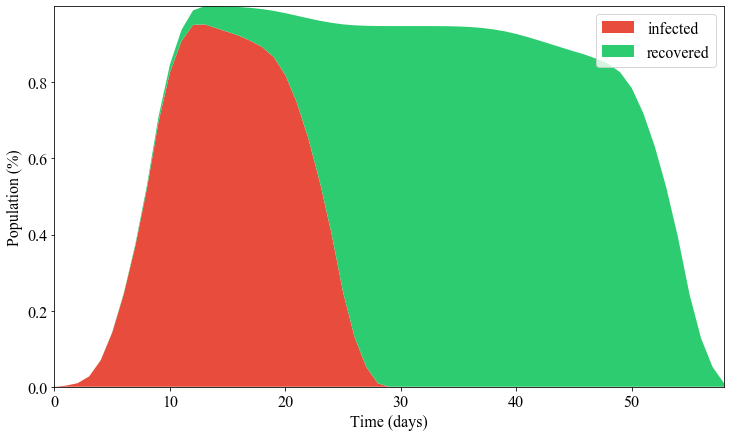

In [12]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["infected", "recovered"]
colors=[COLOR_INFECTED, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_area.pdf")
plt.savefig(base_name + "_area.png")

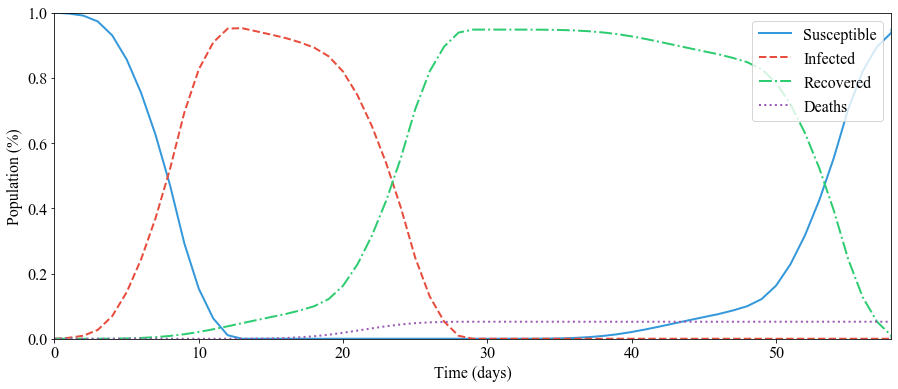

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
ax.plot(x, df_vis["deaths"], label="Deaths", color=COLOR_DEAD, linewidth=linewidth, linestyle=":")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.pdf")
plt.savefig(base_name + "_lines.png")

Text(0, 0.5, 'Population (%)')

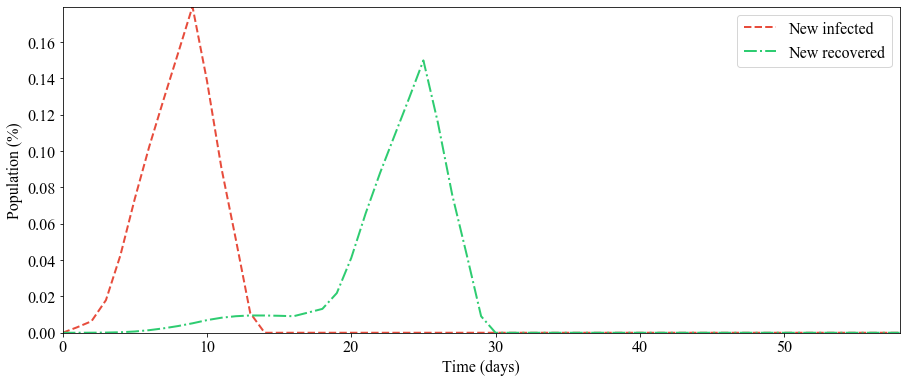

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["new_infected"], label="New infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["new_recovered"], label="New recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
#plt.savefig(base_name + "_lines.pdf")

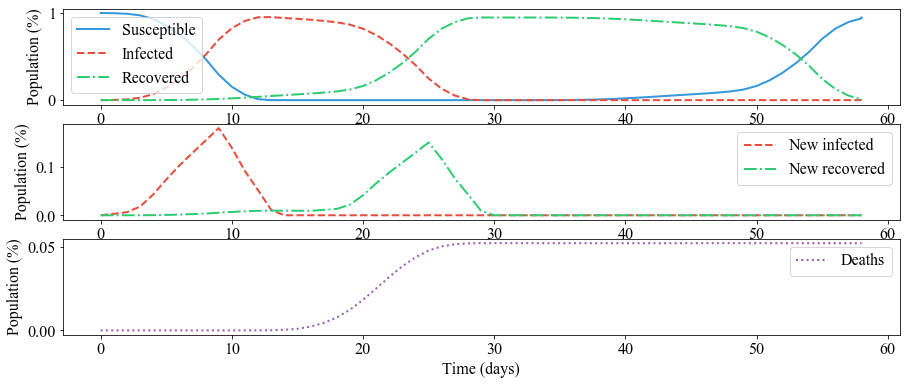

In [15]:
fig, axs = plt.subplots(3, figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
axs[0].plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
axs[0].plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
axs[0].plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
axs[0].set_ylabel("Population (%)")
axs[0].legend()

axs[1].plot(x, df_vis["new_infected"], label="New infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
axs[1].plot(x, df_vis["new_recovered"], label="New recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
axs[1].set_ylabel("Population (%)")
axs[1].legend()

axs[2].plot(x, df_vis["deaths"], label="Deaths", color=COLOR_DEAD, linewidth=linewidth, linestyle=":")
axs[2].set_xlabel("Time (days)")
axs[2].set_ylabel("Population (%)")
axs[2].legend()

#plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.savefig(base_name + "_lines_with_news.pdf")
plt.savefig(base_name + "_lines_with_news.png")

#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc=(0.808,0.295))